# Formation Energy Prediction using *Deml 2016* Descriptors

This notebook uses the method from [Deml 2016](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.93.085142) to predict formation energy of compounds. Specifically, it uses the set of composition based attributes described in the paper to train a machine learning model.

In [1]:
training_file = 'datasets/oqmd_all.data'
delimiter = ' '
comp_col = 'comp'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matminer

from pymatgen import Composition
from matminer.featurizers import composition as cp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold

%matplotlib inline

## Load input files and generate descriptors
The training set is a set of ~2000 compounds with data extracted from the Open Quantum Materials Database (OQMD)

In [3]:
def load_training_set(files, sep):
    """Function to read data files and load them into a Pandas DataFrame"""
        
    if type(files) is not list:
        training_set = pd.read_csv(files, sep=sep)
    else:
        training_set = pd.DataFrame()
        for i in range(len(files)):
            training_set.append(pd.read_csv(files[i], sep=sep[i]))

    return training_set

training_set = load_training_set(training_file, delimiter)

/Users/jimingchen/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


### Create PyMatGen composition objects

In [4]:
comp_objects = [Composition(comp) for comp in training_set[comp_col]]
comp_objects
training_set = training_set.assign(comp_obj=comp_objects)
training_set

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability,comp_obj
0,Li1,-1.892,17.8351,None,0.0,0.004605,0.00460472666667,(Li)
1,Mg1,-1.5396,22.9639,None,0.0,0.002719,0.00271877166667,(Mg)
2,Kr1,0.011256,41.4146,None,7.367,0.015315,0.015314775,(Kr)
3,Na1,-1.2991,32.9826,None,0.0,0.003780,0.00377956333333,(Na)
4,Pd1,-5.15853,15.2088,None,0.0,0.018186,0.0181856433333,(Pd)
5,Fe1,-8.12585,11.5973,2.52045186667,0.0,0.182049,0.182048713333,(Fe)
6,Gd1,-4.65402,32.2627,-0.00223023333333,0.0,0.001047,0.00104724916667,(Gd)
7,Hf1,-9.9232,22.3676,-6.75333333333e-05,0.0,0.032166,0.032166465,(Hf)
8,Ho1,-4.57663,30.5482,0.0072197,0.0,0.000166,0.00055882666667,(Ho)
9,In1,-2.71483,26.816,None,0.0,0.005113,0.00511323666667,(In)


## Compute descriptors using MatMiner
Here, we compute composition based attributes as described in *Deml 2016* using the [MatMiner](https://github.com/hackingmaterials/matminer) implementation of the featurizer.

In [5]:
%%time

def calc_attributes(training_set):
    not_attr = list(training_set) #Non-attribute columns
    training_set_updated = cp.Stoichiometry(p_list=None, num_atoms=True).featurize_dataframe(training_set, col_id="comp_obj")
    training_set_updated = cp.ElementProperty(method="deml").featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.ValenceOrbital(orbitals=["s","p","d"], props=["avg","frac"]).featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.TMetalFraction().featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.ElectronAffinity().featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.ElectronegativityDiff().featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.FERECorrection().featurize_dataframe(training_set_updated, col_id="comp_obj")
    all_cols = list(training_set_updated)
    attr_names = [col for col in all_cols if col not in not_attr]
    return training_set_updated, attr_names

all_descriptors, attr_names = calc_attributes(training_set)

/Users/jimingchen/anaconda2/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-macosx-10.7-x86_64.egg/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ne. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


/Users/jimingchen/anaconda2/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-macosx-10.7-x86_64.egg/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for He. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


/Users/jimingchen/anaconda2/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-macosx-10.7-x86_64.egg/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ar. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


CPU times: user 12min 3s, sys: 4.25 s, total: 12min 7s
Wall time: 12min 7s


## Predicting formation energy

In [6]:
training_set_use = all_descriptors.replace("None", np.nan)
training_set_use = all_descriptors.replace(np.inf, np.nan)
training_set_use = training_set_use.dropna()

training_set_use

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability,comp_obj,Number of atoms,maximum GGAU_Etot,...,maximum EN difference,mean EN difference,minimum EN difference,range EN difference,std_dev EN difference,maximum FERE Correction,mean FERE Correction,minimum FERE Correction,range FERE Correction,std_dev FERE Correction
124,Ca1Se1,-4.77312,26.1704,None,2.167,-2.043629,4.93849999996e-05,"(Se, Ca)",2.0,-1.930,...,1.55,1.550000,1.55,0.00,0.000,0.290000,0.110000,-0.070000,0.360000,0.180000
125,Ca1Te1,-4.22049,32.6162,None,1.644,-1.660656,None,"(Te, Ca)",2.0,-1.930,...,1.10,1.100000,1.10,0.00,0.000,0.290000,0.089830,-0.110341,0.400341,0.200170
174,N1Sc1,-8.21259,10.6951,0.00471035,0.0,-0.999851,1.03342154581,"(Sc, N)",2.0,-5.120,...,1.68,1.680000,1.68,0.00,0.000,0.489758,0.144879,-0.200000,0.689758,0.344879
183,P1Sc1,-6.80001,17.5627,-0.0028465,0.0,-1.071425,0.565892254796,"(Sc, P)",2.0,-4.960,...,0.83,0.830000,0.83,0.00,0.000,0.489758,-0.095121,-0.680000,1.169758,0.584879
228,O1Zn1,-3.82688,9.41469,None,0.0,-0.962428,0.7169025225,"(O, Zn)",2.0,-1.270,...,1.79,1.790000,1.79,0.00,0.000,0.430000,0.330000,0.230000,0.200000,0.100000
241,Cu1O1,-4.06428,9.14286,None,0.0,-0.651135,0.1323755175,"(O, Cu)",2.0,-2.030,...,1.54,1.540000,1.54,0.00,0.000,0.230000,0.143710,0.057419,0.172581,0.086290
247,P1Sc1,-7.36254,18.7363,-0.00020945,0.0,-1.633951,0.003366199796,"(Sc, P)",2.0,-4.960,...,0.83,0.830000,0.83,0.00,0.000,0.489758,-0.095121,-0.680000,1.169758,0.584879
249,Ag1Cl1,-2.7665,21.8201,None,1.115,-0.643623,0.024436015,"(Cl, Ag)",2.0,-0.710,...,1.23,1.230000,1.23,0.00,0.000,0.163756,0.023373,-0.117010,0.280766,0.140383
257,Te1Zn1,-2.67339,28.8916,None,1.453,-0.469457,0.00193691,"(Te, Zn)",2.0,-1.270,...,0.45,0.450000,0.45,0.00,0.000,0.430000,0.159830,-0.110341,0.540341,0.270170
265,O1Ti1,-8.63299,9.60694,-0.00087715,0.0,-2.531496,0.233851730228,"(O, Ti)",2.0,-4.990,...,1.90,1.900000,1.90,0.00,0.000,0.230000,0.141608,0.053216,0.176784,0.088392


In [7]:
#Band gap data
delta_e = np.array(training_set_use["delta_e"], dtype=float)
print delta_e

#Energy range data
delta_e = np.array(training_set_use["delta_e"], dtype=float)

energy_range = np.zeros(np.shape(delta_e), dtype=str)
for i in range(len(delta_e)):
    if delta_e[i] < 0:
        energy_range[i] = "neg"
    else:
        energy_range[i] = "pos"
        
print energy_range

[-2.04362863 -1.6606564  -0.99985123 ..., -2.28491016 -2.28664714
 -1.17868507]
['n' 'n' 'n' ..., 'n' 'n' 'n']


### Predict formation energy range using classifiers

In [8]:
#Classifier step
model1 = RandomForestClassifier(n_estimators=10, criterion="gini", min_samples_split=2)
model1.fit(training_set_use[attr_names], energy_range)
prediction = model1.predict(training_set_use[attr_names])

In [9]:
pd.crosstab(energy_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,n,p
actual,,
n,12388,174
p,339,1918


In [10]:
#Classifier step
model2 = DecisionTreeClassifier()
model2.fit(training_set_use[attr_names], energy_range)
prediction = model2.predict(training_set_use[attr_names])

In [11]:
pd.crosstab(energy_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,n,p
actual,,
n,12399,163
p,339,1918


In [12]:
rf_model = RandomForestRegressor()
rf_model.fit(training_set_use[attr_names], delta_e)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [13]:
prediction = rf_model.predict(training_set_use[attr_names])

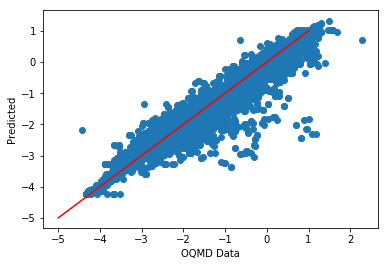

In [14]:
plt.scatter(delta_e, prediction)
plt.plot(range(-5,2), range(-5,2), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [15]:
%%time

errors = cross_val_score(RandomForestRegressor(), training_set_use[attr_names], delta_e, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

0.195343223426
CPU times: user 43 s, sys: 126 ms, total: 43.1 s
Wall time: 43.2 s


### Decision Tree Regressor

In [16]:
dt_model = DecisionTreeRegressor()
dt_model.fit(training_set_use[attr_names], delta_e)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [17]:
dt_prediction = dt_model.predict(training_set_use[attr_names])

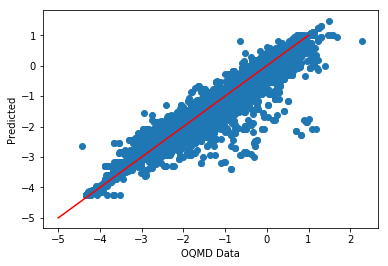

In [18]:
plt.scatter(delta_e, dt_prediction)
plt.plot(range(-5,2), range(-5,2), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [19]:
%%time

errors = cross_val_score(DecisionTreeRegressor(), training_set_use[attr_names], delta_e, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

0.201964621765
CPU times: user 6.41 s, sys: 34.8 ms, total: 6.44 s
Wall time: 6.44 s
